# Superconductivity Regression with H2O GBM

In this notebook, we explore the UCI Superconductivity dataset using H2O's 
Gradient Boosting Machine (GBM). Our goals are:

1. Load and inspect the data.
2. Create train/validation/test splits.
3. Train a baseline GBM model.
4. Perform hyperparameter tuning for GBM.
5. Train a GBM with a log-transformed target.
6. Train a PCA-based GBM model.
7. Compare GBM vs tuned GBM vs log-GBM vs PCA-GBM vs other baselines.
8. Plot learning curves (training vs validation error over trees).

We will focus on predicting `critical_temp` (critical temperature, in Kelvin).


In [4]:
import h2o
from h2o import H2OFrame
from h2o.estimators import H2OGradientBoostingEstimator, H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

h2o.init()

# Load dataset (adjust filename/path if needed)
supercon = h2o.import_file("../images/superconductivty-data/train.csv")

# Quick sanity check
print(supercon.shape)
print(supercon.col_names[:10])

# Define target and features
y = "critical_temp"
X = supercon.col_names.copy()
X.remove(y)

# Train / validation / test split (70 / 15 / 15)
train, valid, test = supercon.split_frame(
    ratios=[0.7, 0.15],
    seed=176
)

print("Train rows:", train.nrows)
print("Valid rows:", valid.nrows)
print("Test rows:",  test.nrows)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 14 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_jesushdzzzz_xfg4gs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.788 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(21263, 82)
['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass']
Train rows: 14944
Valid rows: 3188
Test rows: 3131


## Baseline GBM Model

We first train a simple GBM with modest hyperparameters to establish a baseline.
We will use:

- `ntrees = 100`
- `max_depth = 5`
- `learn_rate = 0.1`

We evaluate performance on:
- Validation set (for model selection)
- Test set (for final performance)


In [5]:
# Baseline GBM
gbm_baseline = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=5,
    learn_rate=0.1,
    seed=176
)

gbm_baseline.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("=== Baseline GBM: Validation Performance ===")
perf_valid_baseline = gbm_baseline.model_performance(valid)
perf_valid_baseline.show()

print("\n=== Baseline GBM: Test Performance ===")
perf_test_baseline = gbm_baseline.model_performance(test)
perf_test_baseline.show()


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
=== Baseline GBM: Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 114.35113479516781
RMSE: 10.693509002903014
MAE: 6.8773736310886955
RMSLE: NaN
Mean Residual Deviance: 114.35113479516781


=== Baseline GBM: Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 130.7661342917119
RMSE: 11.43530210758386
MAE: 7.329962215328263
RMSLE: NaN
Mean Residual Deviance: 130.7661342917119

## Hyperparameter Tuning for GBM

To improve performance, we perform hyperparameter tuning using H2O's 
`H2OGridSearch` with a random search strategy.

We will search over:

- `ntrees` (number of trees)
- `max_depth` (tree depth)
- `learn_rate` (shrinkage)
- `sample_rate` (row sampling)
- `col_sample_rate` (feature sampling)
- `min_rows` (minimum samples per leaf)

We use the **validation set** for model selection and then 
evaluate the best model on the test set.

In [16]:
# ---- Random grid search for tuned GBM ----
hyper_params = {
    "ntrees":            [100, 300, 500, 800],
    "max_depth":         [4, 6, 8, 10, 12],
    "learn_rate":        [0.01, 0.03, 0.05, 0.1],
    "sample_rate":       [0.7, 0.8, 0.9, 1.0],
    "col_sample_rate":   [0.7, 0.8, 0.9, 1.0],
    "min_rows":          [1, 5, 10, 20]
}

search_criteria = {
    "strategy": "RandomDiscrete",
    "max_models": 30,
    "seed": 176,
    "stopping_rounds": 5,
    "stopping_metric": "RMSE",
    "stopping_tolerance": 1e-4
}

gbm_tuned = H2OGridSearch(
    model=H2OGradientBoostingEstimator(
        nfolds=0,
        seed=176,
        stopping_rounds=5,
        stopping_metric="RMSE",
        stopping_tolerance=1e-4
    ),
    hyper_params=hyper_params,
    search_criteria=search_criteria
)

gbm_tuned.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

sorted_grid = gbm_tuned.get_grid(sort_by="rmse", decreasing=False)
print(sorted_grid)

best_gbm_tuned = sorted_grid.models[0]

print("\n=== Best Tuned GBM (Grid Search): Validation Performance ===")
perf_valid_tuned = best_gbm_tuned.model_performance(valid)
perf_valid_tuned.show()

print("\n=== Best Tuned GBM (Grid Search): Test Performance ===")
perf_test_tuned = best_gbm_tuned.model_performance(test)
perf_test_tuned.show()

print("\nBest tuned GBM params:")
print(best_gbm_tuned.get_params())


# ---- Manual GBM variant (gbm_variant_1) ----
gbm_variant_1 = H2OGradientBoostingEstimator(
    ntrees=800,
    max_depth=10,
    learn_rate=0.03,
    sample_rate=0.8,
    col_sample_rate=0.8,
    min_rows=5,
    seed=176,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4
)

gbm_variant_1.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("\n=== GBM Variant 1 (manual config): Validation Performance ===")
perf_valid_var1 = gbm_variant_1.model_performance(valid)
perf_valid_var1.show()

print("\n=== GBM Variant 1 (manual config): Test Performance ===")
perf_test_var1 = gbm_variant_1.model_performance(test)
perf_test_var1.show()

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by increasing rmse
     col_sample_rate    learn_rate    max_depth    min_rows    ntrees    sample_rate    model_ids                                                     rmse
---  -----------------  ------------  -----------  ----------  --------  -------------  ------------------------------------------------------------  ------------------
     1.0                0.03          12.0         10.0        800.0     0.8            Grid_GBM_py_5_sid_9eb4_model_python_1765225055268_7_model_2   9.223805689715963
     0.7                0.01          12.0         5.0         800.0     0.7            Grid_GBM_py_5_sid_9eb4_model_python_1765225055268_7_model_12  9.240837515488785
     0.7                0.05          12.0         5.0         100.0     1.0            Grid_GBM_py_5_sid_9eb4_model_python_1765225055268_7_model_19  9.320290329661285
     0.9          

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 85.07859140163656
RMSE: 9.223805689715963
MAE: 5.0203285657367065
RMSLE: 0.377566035888705
Mean Residual Deviance: 85.07859140163656


=== Best Tuned GBM (Grid Search): Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 91.10945400762134
RMSE: 9.54512723894351
MAE: 5.194156650961609
RMSLE: 0.3816283547466119
Mean Residual Deviance: 91.10945400762134


Best tuned GBM params:
{'model_id': None, 'training_frame': None, 'validation_frame': None, 'nfolds': 0, 'keep_cross_validation_models': True, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'score_each_iteration': False, 'score_tree_interval': 0, 'fold_assignment': 'auto', 'fold_column': None, 'response_column': None, 'ignored_columns': None, 'ignore_const_cols': True, 'offset_column': None, 'weights_column': None, 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'ntrees': 50, 'max_depth': 5, 'min_rows': 10.0, 'nbins': 20, 'nbins_top_level': 1024, 'nbins_cats': 1024, 'r2_stopping': None, 'stopping_rounds': 0, 'stopping_metric': 'auto', 'stopping_tolerance': 0.001, 'max_runtime_secs': 0.0, 'seed': -1, 'build_tree_one_node': False, 'learn_rate': 0.1, 'learn_rate_annealing': 1.0, 'distribution': 'auto', 'quantile_alpha': 0.5, 'tweedie_power': 1.5, 'huber_alpha': 0.9, 'che

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%

=== GBM Variant 1 (manual config): Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 85.3216632367933
RMSE: 9.236972622931892
MAE: 5.032683452587577
RMSLE: 0.38715991772804376
Mean Residual Deviance: 85.3216632367933


=== GBM Variant 1 (manual config): Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 89.79639850757358
RMSE: 9.476096163904922
MAE: 5.190728084370657
RMSLE: 0.38097328721360724
Mean Residual Deviance: 89.79639850757358

## GBM with Log-Transformed Target

The distribution of `critical_temp` is often right-skewed. To reduce the 
influence of very large values, we can model:

\[
y_{\log} = \log(\text{critical_temp} + 1)
\]

Then we train GBM on this transformed target. For simplicity, we will:

- Add a new column `critical_temp_log`.
- Train GBM using this as the target.
- Evaluate metrics in log space (RMSE, MAE on log scale).

In a more detailed analysis, we could exponentiate predictions and compute 
metrics back in the original scale, but here we focus on the log-scale model 
as a separate variant.

In [17]:
# Create log-transformed target in each split
for frame in [train, valid, test]:
    frame["critical_temp_log"] = (frame["critical_temp"] + 1).log()

y_log = "critical_temp_log"
X_log = [col for col in train.col_names if col not in [y, y_log]]

gbm_log = H2OGradientBoostingEstimator(
    ntrees=300,
    max_depth=6,
    learn_rate=0.03,
    seed=176,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4
)

gbm_log.train(
    x=X_log,
    y=y_log,
    training_frame=train,
    validation_frame=valid
)

print("=== Log-GBM: Validation Performance (log scale) ===")
perf_valid_log = gbm_log.model_performance(valid)
perf_valid_log.show()

print("\n=== Log-GBM: Test Performance (log scale) ===")
perf_test_log = gbm_log.model_performance(test)
perf_test_log.show()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
=== Log-GBM: Validation Performance (log scale) ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.16248071061320118
RMSE: 0.4030889611651517
MAE: 0.27129658756760383
RMSLE: 0.14492339549860986
Mean Residual Deviance: 0.16248071061320118


=== Log-GBM: Test Performance (log scale) ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.16968868917985114
RMSE: 0.41193286974924825
MAE: 0.28398296799226047
RMSLE: 0.14109955813292682
Mean Residual Deviance: 0.16968868917985114

## PCA-Based GBM Model

The dataset has 81 numeric features, many of which may be highly correlated.
To reduce redundancy and possibly improve generalization, we can:

1. Convert H2OFrames to pandas DataFrames.
2. Standardize features.
3. Apply PCA to keep (for example) 95% of the variance.
4. Train GBM on the resulting principal components.

We still predict `critical_temp` in the original scale.

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert H2OFrames to pandas
train_pd = train.as_data_frame()
valid_pd = valid.as_data_frame()
test_pd  = test.as_data_frame()

X_cols = X  # original feature columns

X_train_np = train_pd[X_cols].values
X_valid_np = valid_pd[X_cols].values
X_test_np  = test_pd[X_cols].values

y_train_np = train_pd[y].values
y_valid_np = valid_pd[y].values
y_test_np  = test_pd[y].values

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_valid_scaled = scaler.transform(X_valid_np)
X_test_scaled  = scaler.transform(X_test_np)

# PCA to keep 95% of variance
pca = PCA(n_components=0.95, random_state=176)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original feature dimension:", X_train_scaled.shape[1])
print("PCA feature dimension:", X_train_pca.shape[1])

# Build H2OFrames for PCA features + target
pc_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]

train_pca_pd = pd.DataFrame(X_train_pca, columns=pc_names)
train_pca_pd[y] = y_train_np

valid_pca_pd = pd.DataFrame(X_valid_pca, columns=pc_names)
valid_pca_pd[y] = y_valid_np

test_pca_pd = pd.DataFrame(X_test_pca, columns=pc_names)
test_pca_pd[y] = y_test_np

train_pca = h2o.H2OFrame(train_pca_pd)
valid_pca = h2o.H2OFrame(valid_pca_pd)
test_pca  = h2o.H2OFrame(test_pca_pd)

# PCA-based GBM
gbm_pca = H2OGradientBoostingEstimator(
    ntrees=300,
    max_depth=6,
    learn_rate=0.05,
    seed=176,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4
)

gbm_pca.train(
    x=pc_names,
    y=y,
    training_frame=train_pca,
    validation_frame=valid_pca
)

print("=== PCA-GBM: Validation Performance ===")
perf_valid_pca = gbm_pca.model_performance(valid_pca)
perf_valid_pca.show()

print("\n=== PCA-GBM: Test Performance ===")
perf_test_pca = gbm_pca.model_performance(test_pca)
perf_test_pca.show()


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: C

Original feature dimension: 81
PCA feature dimension: 17
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
=== PCA-GBM: Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 122.83473730834422
RMSE: 11.083083384525455
MAE: 6.979809996642365
RMSLE: NaN
Mean Residual Deviance: 122.83473730834422


=== PCA-GBM: Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 139.7898450373149
RMSE: 11.823275562944259
MAE: 7.391505728713786
RMSLE: NaN
Mean Residual Deviance: 139.7898450373149

## Additional Baselines: Random Forest and Linear Regression

To better understand the effectiveness of GBM, we compare it with:

- Random Forest (tree ensemble without boosting).
- Linear Regression (GLM with Gaussian family).

These serve as baselines for model complexity and performance.


In [19]:
# Random Forest
rf_model = H2ORandomForestEstimator(
    ntrees=300,
    max_depth=20,
    seed=176
)
rf_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("=== Random Forest: Validation Performance ===")
perf_valid_rf = rf_model.model_performance(valid)
perf_valid_rf.show()

print("\n=== Random Forest: Test Performance ===")
perf_test_rf = rf_model.model_performance(test)
perf_test_rf.show()


# Linear Regression (GLM)
glm_model = H2OGeneralizedLinearEstimator(
    family="gaussian",
    lambda_=0.0,  # no regularization to start
    compute_p_values=False
)
glm_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("\n=== GLM (Linear Regression): Validation Performance ===")
perf_valid_glm = glm_model.model_performance(valid)
perf_valid_glm.show()

print("\n=== GLM (Linear Regression): Test Performance ===")
perf_test_glm = glm_model.model_performance(test)
perf_test_glm.show()


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
=== Random Forest: Validation Performance ===


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 86.51719132275494
RMSE: 9.301461784190426
MAE: 5.183396244274772
RMSLE: 0.38486030833117885
Mean Residual Deviance: 86.51719132275494


=== Random Forest: Test Performance ===


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 92.71613458663302
RMSE: 9.628921776950575
MAE: 5.35132874000798
RMSLE: 0.38763627881532764
Mean Residual Deviance: 92.71613458663302

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

=== GLM (Linear Regression): Validation Performance ===


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 300.86679614644896
RMSE: 17.345512276852734
MAE: 13.137367123581909
RMSLE: NaN
Mean Residual Deviance: 300.86679614644896
R^2: 0.748440311785104
Null degrees of freedom: 3187
Residual degrees of freedom: 3106
Null deviance: 3813003.69114874
Residual deviance: 959163.3461148792
AIC: 27406.008489222335


=== GLM (Linear Regression): Test Performance ===


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 331.1254109219166
RMSE: 18.196851676098166
MAE: 13.815679413947812
RMSLE: NaN
Mean Residual Deviance: 331.1254109219166
R^2: 0.717332292023316
Null degrees of freedom: 3130
Residual degrees of freedom: 3049
Null deviance: 3667747.753066183
Residual deviance: 1036753.661596521
AIC: 27219.01179236774

## Model Comparison

We now compare the main models:

- Baseline GBM
- Tuned GBM
- Log-GBM (trained on log-transformed target)
- PCA-based GBM
- Random Forest
- Linear Regression (GLM)

We will collect RMSE and MAE on both validation and test sets 
to see which approach performs best and generalizes the most reliably.


In [ ]:
def extract_rmse_mae(perf):
    return perf.rmse(), perf.mae()

results = []

# Baseline GBM
results.append({
    "model": "GBM Baseline",
    "valid_RMSE": perf_valid_baseline.rmse(),
    "valid_MAE":  perf_valid_baseline.mae(),
    "test_RMSE":  perf_test_baseline.rmse(),
    "test_MAE":   perf_test_baseline.mae()
})

# Tuned GBM
results.append({
    "model": "GBM Tuned",
    "valid_RMSE": perf_valid_tuned.rmse(),
    "valid_MAE":  perf_valid_tuned.mae(),
    "test_RMSE":  perf_test_tuned.rmse(),
    "test_MAE":   perf_test_tuned.mae()
})

# Manual GBM variant
results.append({
    "model": "GBM Variant 1 (manual)",
    "valid_RMSE": perf_valid_var1.rmse(),
    "valid_MAE":  perf_valid_var1.mae(),
    "test_RMSE":  perf_test_var1.rmse(),
    "test_MAE":   perf_test_var1.mae()
})

# Log-GBM (log scale)
results.append({
    "model": "GBM Log-Target (log scale)",
    "valid_RMSE": perf_valid_log.rmse(),
    "valid_MAE":  perf_valid_log.mae(),
    "test_RMSE":  perf_test_log.rmse(),
    "test_MAE":   perf_test_log.mae()
})

# PCA-GBM
results.append({
    "model": "GBM PCA",
    "valid_RMSE": perf_valid_pca.rmse(),
    "valid_MAE":  perf_valid_pca.mae(),
    "test_RMSE":  perf_test_pca.rmse(),
    "test_MAE":   perf_test_pca.mae()
})

# Random Forest
results.append({
    "model": "Random Forest",
    "valid_RMSE": perf_valid_rf.rmse(),
    "valid_MAE":  perf_valid_rf.mae(),
    "test_RMSE":  perf_test_rf.rmse(),
    "test_MAE":   perf_test_rf.mae()
})

# GLM
results.append({
    "model": "GLM (Linear Regression)",
    "valid_RMSE": perf_valid_glm.rmse(),
    "valid_MAE":  perf_valid_glm.mae(),
    "test_RMSE":  perf_test_glm.rmse(),
    "test_MAE":   perf_test_glm.mae()
})

results_df = pd.DataFrame(results)
results_df


,model,valid_RMSE,valid_MAE,test_RMSE,test_MAE
0,GBM Baseline,10.693509,6.877374,11.435302,7.329962
1,GBM Tuned,9.223806,5.020329,9.545127,5.194157
2,GBM Log-Target (log scale),0.403089,0.271297,0.411933,0.283983
3,GBM PCA,11.083083,6.979810,11.823276,7.391506
4,Random Forest,9.301462,5.183396,9.628922,5.351329
5,GLM (Linear Regression),17.345512,13.137367,18.196852,13.815679
6,GLM (Linear Regression),17.345512,13.137367,18.196852,13.815679


## Learning Curves: Training vs Validation RMSE

Finally, we inspect the learning curves of the baseline and tuned GBM models.
We use the `scoring_history()` to plot RMSE over the number of trees:

- Training RMSE
- Validation RMSE

This helps us visually assess underfitting/overfitting and the effect of 
early stopping.


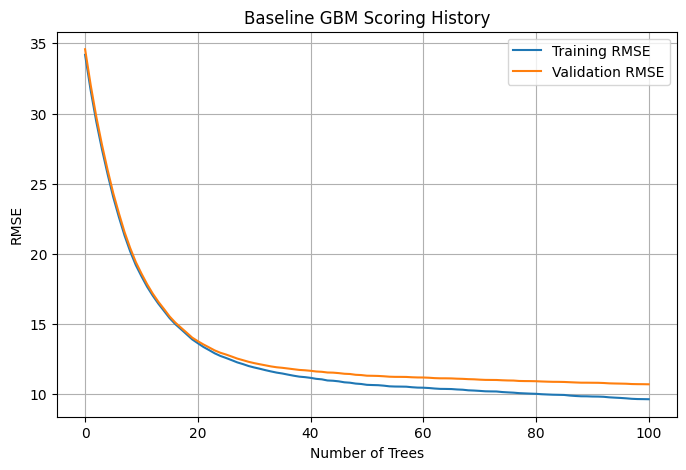

Saved plot to: ../output/gbm_baseline_scoring.png


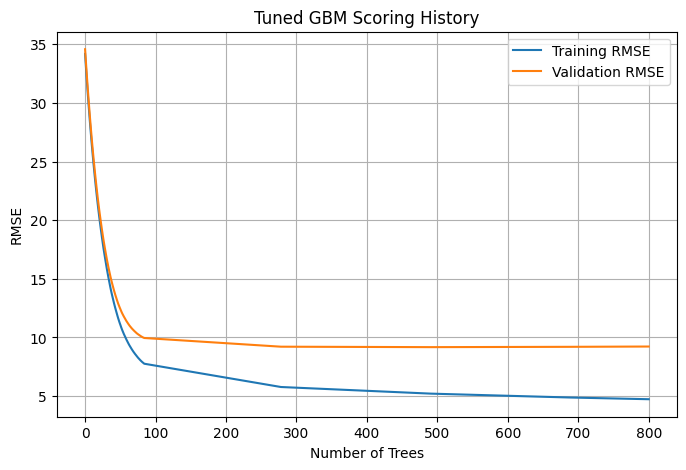

Saved plot to: ../output/gbm_tuned_scoring.png


In [15]:
import os
import matplotlib.pyplot as plt

def plot_scoring_history(model, title, filename, output_dir="../output"):
    # scoring_history() already returns a pandas DataFrame in your setup
    sh = model.scoring_history()
    cols = sh.columns

    if "training_rmse" not in cols:
        print(f"No training_rmse in scoring history for {title}")
        return

    x = sh["number_of_trees"]

    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)

    plt.figure(figsize=(8, 5))
    plt.plot(x, sh["training_rmse"], label="Training RMSE")
    if "validation_rmse" in cols:
        plt.plot(x, sh["validation_rmse"], label="Validation RMSE")

    plt.xlabel("Number of Trees")
    plt.ylabel("RMSE")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Save first, then show
    plt.savefig(filepath, bbox_inches="tight")
    plt.show()

    print(f"Saved plot to: {filepath}")

plot_scoring_history(gbm_baseline, "Baseline GBM Scoring History", "gbm_baseline_scoring.png")
plot_scoring_history(best_gbm_tuned, "Tuned GBM Scoring History", "gbm_tuned_scoring.png")



In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_log_model_original_scale(model, frame, target_col="critical_temp"):
    """
    model: H2O GBM trained on log(target + 1)
    frame: H2OFrame (train/valid/test)
    """
    # True values in original scale
    y_true = frame[target_col].as_data_frame().values.ravel()
    
    # Predicted log values
    preds_log_h2o = model.predict(frame)
    y_pred_log = preds_log_h2o["predict"].as_data_frame().values.ravel()
    
    # Back-transform: exp(log(y+1)) - 1
    y_pred = np.exp(y_pred_log) - 1.0
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Evaluate on train/valid/test
rmse_train_log_orig, mae_train_log_orig = evaluate_log_model_original_scale(gbm_log, train)
rmse_valid_log_orig, mae_valid_log_orig = evaluate_log_model_original_scale(gbm_log, valid)
rmse_test_log_orig,  mae_test_log_orig  = evaluate_log_model_original_scale(gbm_log, test)

print("=== Log-GBM evaluated in ORIGINAL scale (Kelvin) ===")
print(f"Train  RMSE: {rmse_train_log_orig:.4f}, MAE: {mae_train_log_orig:.4f}")
print(f"Valid  RMSE: {rmse_valid_log_orig:.4f}, MAE: {mae_valid_log_orig:.4f}")
print(f"Test   RMSE: {rmse_test_log_orig:.4f},  MAE: {mae_test_log_orig:.4f}")


gbm prediction progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
=== Log-GBM evaluated in ORIGINAL scale (Kelvin) ===
Train  RMSE: 10.4282, MAE: 6.4757
Valid  RMSE: 11.3982, MAE: 7.0456
Test   RMSE: 12.0001,  MAE: 7.3832


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
